# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.722221,True,5.071725
1,-0.856812,False,0.609465
2,-2.391374,False,-0.506651
3,-1.918036,False,-0.601452
4,0.882127,True,5.128811
...,...,...,...
995,-0.596721,False,-0.706700
996,-1.818413,False,1.128554
997,-3.046719,False,0.993531
998,-1.384053,False,0.371187


<AxesSubplot: xlabel='v0'>

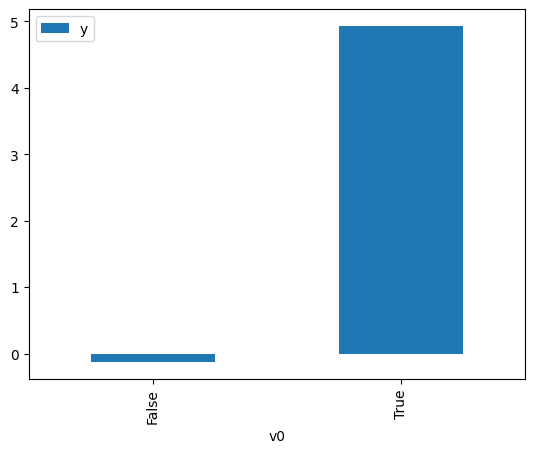

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

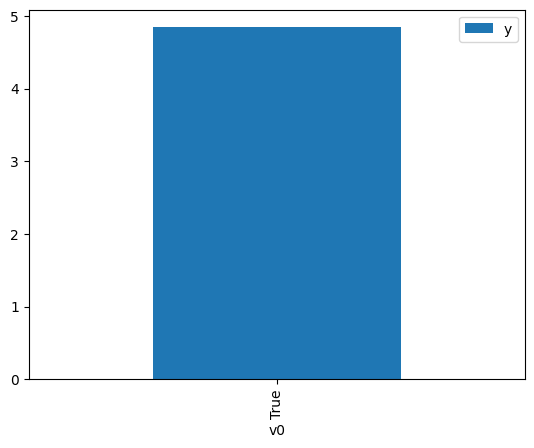

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.035343,False,-0.917536,0.449275,2.225808
1,-1.869314,False,0.543420,0.988948,1.011176
2,-0.991416,False,0.842189,0.911233,1.097414
3,0.063474,False,0.803343,0.432175,2.313878
4,-0.198865,False,2.422522,0.592436,1.687946
...,...,...,...,...,...
995,-3.340516,False,-1.751851,0.999703,1.000297
996,-1.990039,False,1.798673,0.991771,1.008298
997,-0.332246,False,0.252788,0.668856,1.495091
998,-2.192881,False,-0.233216,0.994994,1.005031


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.398696,True,6.202966,0.295899,3.379536
1,-1.319608,True,5.007641,0.041558,24.063004
2,-1.442337,True,2.537224,0.031041,32.215849
3,0.745408,True,5.927793,0.875979,1.141579
4,-1.043505,True,4.435077,0.078910,12.672713
...,...,...,...,...,...
995,-1.172192,True,4.394574,0.058710,17.032929
996,-0.127205,True,5.321446,0.450834,2.218114
997,-0.612088,True,4.648889,0.198896,5.027765
998,-1.693558,True,4.918941,0.016948,59.005295


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.880
Model:                            OLS   Adj. R-squared (uncentered):              0.880
Method:                 Least Squares   F-statistic:                              3654.
Date:                Wed, 16 Nov 2022   Prob (F-statistic):                        0.00
Time:                        14:33:35   Log-Likelihood:                         -1426.9
No. Observations:                1000   AIC:                                      2858.
Df Residuals:                     998   BIC:                                      2868.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1225      0.027      4.552      0.000       0.070       0.175
x2             4.9189      0.058     84.330      0.000       4.804       5.033
==============================================================================
Omnibus:                        0.319   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.853   Jarque-Bera (JB):                0.406
Skew:                          -0.018   Prob(JB):                        0.816
Kurtosis:                       2.908   Cond. No.                         2.19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""